In [1]:
#Boston House Prices Regression Analysis

In [2]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import stats

In [3]:
#load data
boston = load_boston()
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [4]:
#convert into data frame
boston_df = pd.DataFrame(boston.data, columns = boston.feature_names)
boston_df["MEDV"] = boston.target

In [5]:
#define features and dependant variable
X = boston_df[boston_df.columns.difference(["MEDV"])]
y = boston_df["MEDV"]

In [6]:
#normalize data sets
X = X.apply(lambda x: ((x - x.min()) / (x.max() - x.min())), axis = 0)

In [7]:
#get to know the data
boston_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [48]:
#get to know the data
boston_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(14)
memory usage: 55.5 KB


In [46]:
#CHAS value count
boston_df["CHAS"].value_counts().to_frame()

,CHAS
0.0,471
1.0,35


In [52]:
#check for missing values
boston_df.isnull().sum().to_frame("Missing Values")

,Missing Values
CRIM,0
ZN,0
INDUS,0
CHAS,0
NOX,0
RM,0
AGE,0
DIS,0
RAD,0
TAX,0


In [78]:
#check for duplicated rows
print("Duplicated Rows:", boston_df.duplicated().sum())

Duplicated rows: 0


In [60]:
#check feature variance
variance = X.var()
variance.to_frame("Variance")

,Variance
AGE,0.084039
B,0.052995
CHAS,0.064513
INDUS,0.063242
LSTAT,0.038828
NOX,0.056850
PTRATIO,0.053044
RM,0.018124
TAX,0.103450
ZN,0.054394


In [13]:
#remove CRIM
del X["CRIM"]

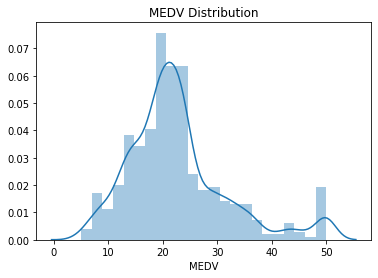

In [14]:
#check MEDV distribution
sn.distplot(boston_df["MEDV"], bins = "auto").set_title("MEDV Distribution")
plt.show()

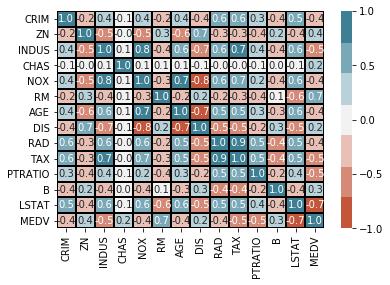

In [15]:
#correlation matrix
corr = boston_df.corr()
ax = sn.heatmap(corr, vmin = -1, vmax = 1, center = 0, cmap = sn.diverging_palette(20, 220, n = 7),
                fmt = ".1f", linewidths = 1, linecolor = "black", annot = True,
                cbar_kws = {"ticks" : [-1, -.5, 0, 0.5, 1]})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [16]:
#remove RAD and DIS
X = X.drop(["RAD", "DIS"], axis = 1)

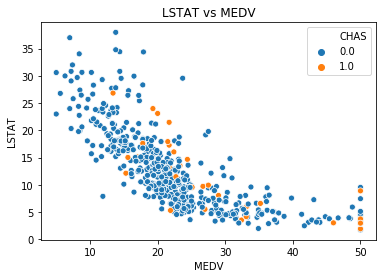

In [57]:
#plot highly correlated features with MEDV
MvL = sn.scatterplot(x = "MEDV", y = "LSTAT", hue = "CHAS", data = boston_df)
MvL.set_title("LSTAT vs MEDV")
plt.show()

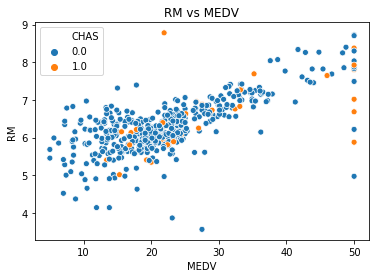

In [18]:
#plot highly correlated features with MEDV
MvR = sn.scatterplot(x = "MEDV", y = "RM", hue = "CHAS", data = boston_df)
MvR.set_title("RM vs MEDV")
plt.show()

In [70]:
#anova test for CHAS
df = boston_df[["MEDV", "CHAS"]]
F, p = stats.f_oneway(df[df.CHAS == 0].MEDV,
                      df[df.CHAS == 1].MEDV)
print("CHAS:", "%f" % p)

CHAS: 0.000074


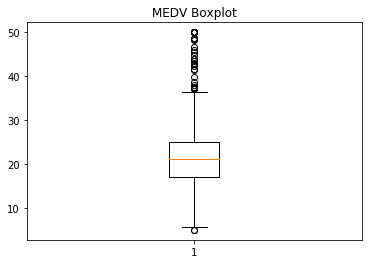

In [20]:
#check for outliers on MEDV
plt.boxplot(boston_df["MEDV"], whis = 1.5)
plt.title("MEDV Boxplot")
plt.show()

In [61]:
#outlier values
Q1 = boston_df["MEDV"].quantile(0.25)
Q3 = boston_df["MEDV"].quantile(0.75)
IQR = Q3 - Q1

boston_df[(df["MEDV"] < Q1 - 1.5 * IQR ) | (boston_df["MEDV"] > Q3 + 1.5 * IQR)]["MEDV"].to_frame()

,MEDV
97,38.7
98,43.8
157,41.3
161,50.0
162,50.0
163,50.0
166,50.0
179,37.2
180,39.8
182,37.9


In [22]:
#define train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

In [63]:
#train shape
X_train.shape, y_train.shape

((354, 10), (354,))

In [24]:
#test shape
X_test.shape, y_test.shape

((152, 10), (152,))

In [25]:
#add cross-validation step
kf = KFold(n_splits = 10)

In [26]:
#linear regression for reference
reg0 = LinearRegression()
reg0.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
#predictions
y_pred0 = reg0.predict(X_test)

In [65]:
#test error metrics
rmse_0 = (np.sqrt(mean_squared_error(y_test, y_pred0)))
r2_0 = r2_score(y_test, y_pred0)

print("LM - Error Metrics:")
print("Test RMSE:" "\t" "%.3f" % rmse_0)
print("Test R^2:" "\t" "%.3f" % r2_0)

LM - Error Metrics:
Test RMSE:	5.788
Test R^2:	0.586


In [29]:
#extreme gradient boosted trees
reg = xgb.XGBRegressor(objective = "reg:squarederror",
                          colsample_bytree = 0.3, learning_rate = 0.1, 
                          max_depth = 5, alpha = 10, n_estimators = 500,
                          random_state = 123)

reg.fit(X_train.values, y_train.values)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [68]:
#train error metrics
score = reg.score(X_train.values, y_train.values)
print("Train R^2:" "\t" "%.3f" % score)

Train R^2:	1.000


In [80]:
#cross-validation error metrics
scores = cross_val_score(reg, X_train.values, y_train.values, cv = kf, scoring = "r2")

print("Cross-Validation R^2 Scores:", "\t", np.sort(np.around(scores, decimals = 3)))
print("Cross-Validation R^2 Scores Range:" "\t" "%.3f" % (scores.max() - scores.min()))
print("Cross-Validation R^2 Scores Mean:" "\t" "%.3f" % scores.mean())

Cross-Validation R^2 Scores: 	 [0.785 0.786 0.807 0.819 0.852 0.861 0.888 0.904 0.912 0.941]
Cross-Validation R^2 Scores Range:	0.155
Cross-Validation R^2 Scores Mean:	0.855


In [32]:
#predictions
y_pred = reg.predict(X_test.values)

In [33]:
#test error metrics
rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)

print("XGB - Error Metrics:")
print("Test RMSE:" "\t" "%.3f" % rmse)
print("Test R^2:" "\t" "%.3f" % r2)

XGB - Error Metrics:
Test RMSE:	4.377
Test R^2:	0.763


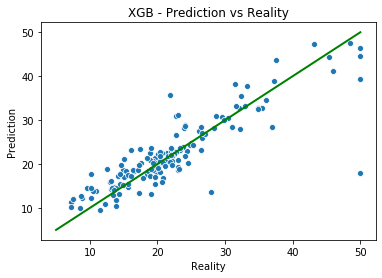

In [34]:
#comparing reality vs predictions
PvR = sn.scatterplot(x = y_test, y = y_pred)
PvR.set_title("XGB - Prediction vs Reality")
PvR.set_xlabel("Reality")
PvR.set_ylabel("Prediction")
plt.plot([y.min(), y.max()], [y.min(), y.max()], color = "g", lw = 2)
plt.show()

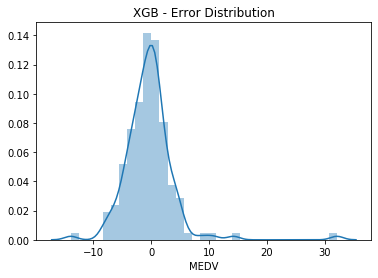

In [35]:
#error distribution
errors = y_test - y_pred
sn.distplot(errors, bins = "auto").set_title("XGB - Error Distribution")
plt.show()

In [36]:
#svm
reg1 = SVR(kernel = "rbf", C = 200, gamma = "auto")
reg1.fit(X_train, y_train)

SVR(C=200, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [37]:
#train error metrics
score1 = reg1.score(X_train, y_train)
print("Train R^2:" "\t" "%.3f" % score1)

Train R^2:	0.831


In [79]:
#cross-validation error metrics
scores1 = cross_val_score(reg1, X_train, y_train, cv = kf, scoring = "r2")

print("Cross-Validation R^2 Scores:", "\t", np.sort(np.around(scores1, decimals = 3)))
print("Cross-Validation R^2 Scores Range:" "\t" "%.3f" % (scores1.max() - scores1.min()))
print("Cross-Validation R^2 Scores Mean:" "\t" "%.3f" % scores1.mean())

Cross-Validation R^2 Scores: 	 [0.606 0.643 0.809 0.823 0.829 0.848 0.87  0.878 0.898 0.898]
Cross-Validation R^2 Scores Range:	0.292
Cross-Validation R^2 Scores Mean:	0.810


In [39]:
#predictions
y_pred1 = reg1.predict(X_test)

In [40]:
#test error metrics
rmse_1 = (np.sqrt(mean_squared_error(y_test, y_pred1)))
r2_1 = r2_score(y_test, y_pred1)

print("SVM - Error Metrics:")
print("RMSE:" "\t" "%.3f" % rmse_1)
print("R^2:" "\t" "%.3f" % r2_1)

SVM - Error Metrics:
RMSE:	4.707
R^2:	0.726


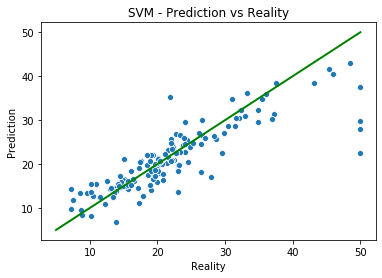

In [41]:
#comparing reality vs predictions
PvR = sn.scatterplot(x = y_test, y = y_pred1)
PvR.set_title("SVM - Prediction vs Reality")
PvR.set_xlabel("Reality")
PvR.set_ylabel("Prediction")
plt.plot([y.min(), y.max()], [y.min(), y.max()], color = "g", lw = 2)
plt.show()

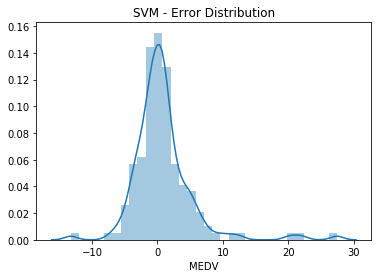

In [42]:
#error distribution
errors1 = y_test - y_pred1
sn.distplot(errors1, bins = "auto").set_title("SVM - Error Distribution")
plt.show()

In [43]:
#summary
print("Summary", "\n")
print("Linear Model:")
print("RMSE:" "\t" "%.3f" % rmse_0)
print("R^2:" "\t" "%.3f" % r2_0, "\n")
print("XGB:")
print("RMSE:" "\t" "%.3f" % rmse)
print("R^2:" "\t" "%.3f" % r2, "\n")
print("SVM:")
print("RMSE:" "\t" "%.3f" % rmse_1)
print("R^2:" "\t" "%.3f" % r2_1)

Summary 

Linear Model:
RMSE:	5.788
R^2:	0.586 

XGB:
RMSE:	4.377
R^2:	0.763 

SVM:
RMSE:	4.707
R^2:	0.726
